In [1]:
# Imports
import networkx as nx
import pandas as pd
import numpy as np
import random
import wikipedia
import time
import pickle
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from operator import itemgetter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from config import *
from transformers import *
from spectral_clustering import *
from pymagnitude import *
from predict import *
from pprint import pprint

## Creation of dataframes containing nodes and edges information

In [2]:
# Loading data
edge_list = pd.read_csv("ml-nlp-ai-ann-chatbot-ia-dataviz-dist2.tsv", sep = "\t")
edge_list.head()

,source,target,depth
0,intelligent agent,software agent,1
1,intelligent agent,cognitive architecture,1
2,intelligent agent,cognitive radio,1
3,intelligent agent,cybernetics,1
4,intelligent agent,computer science,1


First, we create the node dataframe by filling the 'url' and 'keywords' columns.

In [3]:
df_node = pd.DataFrame(columns=['name','url', 'keywords'])
df_node['name'] = pd.unique(edge_list.source.append(edge_list.target))

In [4]:
def get_url(node):
    "Robust to spelling and lower case/upper case errors"
    try:
        return wikipedia.page(node).url
    except wikipedia.DisambiguationError as e:
        s = random.choice(e.options)
        return "https://en.wikipedia.org/wiki/" + s.replace(" ", "_")
    except:
        return "https://en.wikipedia.org/wiki/" + node.replace(" ", "_")

In [5]:
# takes a long time to run, load a pickle by default
is_saved = True

if not is_saved:
    urls = []
    for name in df_node.name:
        urls.append(get_url(name))
    with open('urls.pickle', 'wb') as handle:
        pickle.dump(urls, handle)
        
else:
    with open('urls.pickle', 'rb') as handle:
        urls = pickle.load(handle)  

In [6]:
df_node['url'] = urls

Then, we create lists of keywords for each page by doing TF-IDF on pages summaries.

In [7]:
def get_summary(node, num_chars=1000):
    "Robust to spelling and lower case/upper case errors"
    try:
        return wikipedia.summary(node, chars=num_chars)[:num_chars] # summary may not return exactly num_chars
    except wikipedia.DisambiguationError as e:
        print(e.options)
        s = random.choice(e.options)
        # handling special cases for our dataset (some options do not have any associated pages)
        if "Mark" in e.options[0]:
            s = e.options[0]
        elif "visit" in e.options[0] or "Transcript" in e.options[0]:
            s = e.options[1]
        elif "Jim" in e.options[0]:
            s = e.options[2]
        print(s)
        return wikipedia.summary(s, chars=num_chars)[:num_chars]
    except:
        return ''

In [8]:
def pre_process(text):
    text=text.lower()
    text=re.sub("</?.*?>"," <> ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

In [9]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(idx):
    
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs[idx]]))
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    
    #we only need to do it once
    feature_names=cv.get_feature_names()
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

In [10]:
# takes a long time to run, summaries are saved in a pickle by default
is_saved = True

if not is_saved:
    counter = 0
    docs = []
    
    for name in df_node['name']:
        print(counter)
        counter += 1
        docs.append(pre_process(get_summary(name)))

    with open('summaries.pickle', 'wb') as handle:
        pickle.dump(docs, handle)
        
else:
    with open('summaries.pickle', 'rb') as handle:
        docs = pickle.load(handle)

In [11]:
stopwords = get_stop_words("stopwords.txt")
cv = CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector = cv.fit_transform(docs)

In [12]:
# TF-IDF transformer
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [13]:
# adding keywords to df_node
df_node['keywords'] = [list(get_keywords(idx).keys()) for idx in range(len(df_node))]

In [14]:
df_node.head()

,name,url,keywords
0,intelligent agent,https://en.wikipedia.org/wiki/Intelligent_agent,"[intelligent, agents, agent, autonomous, abstr..."
1,chatbot,https://en.wikipedia.org/wiki/Chatbot,"[chatbots, apps, keywords, conversational, pro..."
2,artificial neural network,https://en.wikipedia.org/wiki/Artificial_neura...,"[cats, cat, neurons, images, biological, ann, ..."
3,artificial intelligence,https://en.wikipedia.org/wiki/Artificial_intel...,"[ai, intelligence, machines, humans, considere..."
4,weak ai,https://en.wikipedia.org/wiki/Weak_AI,"[ai, narrow, weak, minds, intelligence, proble..."


In [15]:
df_node.to_csv(DF_NODE_FILENAME)

Then, we create the edge dataframe, containing links between nodes.

In [16]:
df_edge = pd.DataFrame(columns=['source','target'])
df_edge['source'] = [df_node[df_node.name==name].index.values[0] for name in edge_list.source]
df_edge['target'] = [df_node[df_node.name==name].index.values[0] for name in edge_list.target]

In [17]:
df_edge.head()

,source,target
0,0,95
1,0,69
2,0,103
3,0,94
4,0,99


In [18]:
df_edge.to_csv(DF_EDGE_FILENAME)

In [19]:
# Building graph
graph = nx.from_pandas_edgelist(edge_list, "source", "target", edge_attr=True)
print("Number of nodes: ", len(graph))

Number of nodes:  1166


In [20]:
# one article queries
# mix of central articles and small topics
query_1 = 'machine learning'
query_2 = 'data visualization'
query_3 = 'natural language processing'
query_4 = 'artificial intelligence'
query_5 = 'universal basic income'
query_6 = 'word2vec'
query_7 = 'analytics'

# many articles queries. Can't get anything out of it
query_8 = 0
query_9 = 0

# linear algebra magic . Can't get anything out of it
query_10 = 0
query_11 = 0

all_queries = [query_1,query_2,query_3,query_4,query_5,query_6,query_7]


cluster_1 = ['neural architecture search', 'hyperparameter optimization', 'model selection', 
             'self-tuning', 'automated machine learning']

cluster_2 = ['data visualization', 'data art', 'visual analytics', 'exploratory data analysis',
             'information visualization']

cluster_3 = ['machine learning', 'artificial intelligence', 'genetic algorithm', 'evolutionary computation',
             'reinforcement learning']

cluster_4 = ['natural language processing', 'latent dirichlet allocation', 'word2vec', 'speech processing',
             'information retrieval']

cluster_5 = ['convolutional neural network', 'deep learning', 'artificial neural network',
             'computational neuroscience', 'blue brain project']

cluster_6 = ['universal basic income', 'mincome', 'minimum wage', 'quatinga velho', 'job guarantee']

nodes_to_plot = cluster_1 + cluster_2 + cluster_3 + cluster_4 + cluster_5 + cluster_6

# Node to vector representations

Algorithms:
- Node2Vec

Nodes appearing in the same context will have similar embeddings. The context is defined as sequences of nodes built by random walks.

Why not just recommend neighboring nodes instead of bothering with embeddings ? The connectedness of the nodes in a graph does not necessarily mean that they are semantically similar. Besides embeddings allow us to do linear algebra on the representations. This is especially useful for queries with multiple keywords.

In [21]:
def plot_projection(node_vectors, nodes, dim=2, projection_method=PCA, perplexity=3):
    """Plot the projection of embeddings after applying a dimensionality reduction method."""
    if projection_method == TSNE:
        projection = projection_method(n_components=dim, perplexity=perplexity)
    else:
        projection = projection_method(n_components=dim)
    projections = projection.fit_transform(node_vectors)
    
    plt.figure(figsize=(10,7))
    plt.scatter(projections[:,0], projections[:,1])
    for i, node in enumerate(nodes):
        plt.annotate(node, xy=(projections[i,0], projections[i,1]))
    plt.title("{} over {} dimensions".format(type(projection).__name__, dim))
    plt.show()

In [22]:
node2vec = Node2Vec(graph, walk_length=40, num_walks=10, quiet=True, p=1, q=1)
# For small datasets Skip-gram and 10-20 negative samples are recommended
node2vec_model = node2vec.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [23]:
node2vec_model.save(NODE2VEC_FILENAME)

In [24]:
query_answers_node2vec(query_3, node2vec_model, df_node, 10, return_idx=False)

{'natural language processing': 1.0,
 'spoken dialogue system': 0.8140469789505005,
 'language and communication technologies': 0.8067601919174194,
 'language technology': 0.8065967559814453,
 'transformer (machine learning model)': 0.7994508743286133,
 'truecasing': 0.7898811101913452,
 '1 the road': 0.7882891297340393,
 'automated essay scoring': 0.7835820913314819,
 'biomedical text mining': 0.7716552019119263,
 'question answering': 0.7443215847015381}

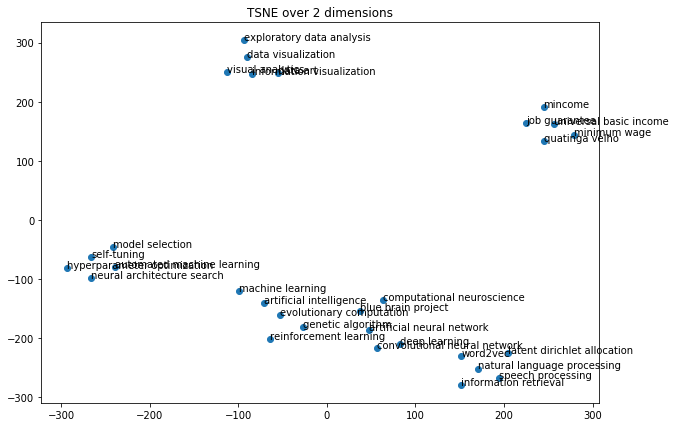

In [25]:
node_vectors = node2vec_model.wv[nodes_to_plot]
plot_projection(node_vectors, nodes_to_plot, projection_method=TSNE, perplexity=4)

## Spectral clustering on hyperlink graph

In [26]:
ordered_nodes = list(sorted(graph.nodes()))
A = nx.adjacency_matrix(graph,nodelist=ordered_nodes)
proj = laplacian_eigenmaps(A,dim=100,sigma=None,epsilon=None,normalize=None,use_similarity=False)

In [27]:
name2idx_adjacency = {}
idx = 0
for node in ordered_nodes:
    name2idx_adjacency[node] = idx
    idx += 1

In [28]:
with open(SPECTRAL_CLUSTERING_FILENAME,'wb') as f:
    pickle.dump(proj,f)
    pickle.dump(ordered_nodes,f)
    pickle.dump(name2idx_adjacency,f)

In [29]:
query_answers_spectral(query_6, proj, ordered_nodes, df_node, name2idx_adjacency, topn=10, return_idx=False)

{'word2vec': 1.0,
 'glove (machine learning)': 0.9724732751019628,
 'thought vector': 0.9724732751019627,
 'vector space model': 0.9724732751019627,
 'feature learning': 0.9724732751019627,
 'language model': 0.9724732751019627,
 'normalized compression distance': 0.9724732751019627,
 'document-term matrix': 0.9724732751019626,
 'feature extraction': 0.9724732751019626,
 'fasttext': 0.9724732751019626}

In [30]:
def get_vectors_spectral(nodes, proj, name2idx_adjacency):
    vectors = []
    for node in nodes:
        idx = name2idx_adjacency[node]
        vector = proj[idx]
        vectors.append(vector.tolist()[0])
    return vectors

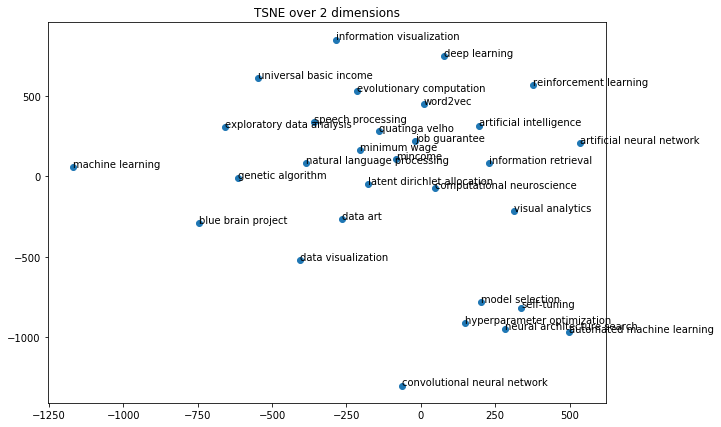

In [31]:
node_vectors = get_vectors_spectral(nodes_to_plot,proj,name2idx_adjacency)
plot_projection(node_vectors, nodes_to_plot, projection_method=TSNE, perplexity=4)

# Combining Node attributes and graph structure

- Obtain representations of keywords extracted from summaries as fasttext or bert embeddings
- Perform walks and average embeddings

## Scalability limitations

- We would need a lot of computational resources for parsing the text and learning word embeddings from all these summaries. However one can use pre-trained embeddings to fix this issue.

In [32]:
# Load pretrained fasttext model
vectors = Magnitude("wiki-news-300d-1M-subword.magnitude")
node2vec = Node2Vec(graph, walk_length=40, num_walks=10, quiet=True, p=1, q=1)
walks = node2vec.walks

In [33]:
def fastt_embedding(text):
    "Encode text using Fasttext model."
    return vectors.query(text.split()).mean(axis=0)

In [34]:
def get_weighted_walk_of_embeddings(walk, embeddings_dict, source_weight=0.75):
    "Given a source embedding and a walk of embeddings, returns the weighted average of embeddings."
    walk_weight = (1-source_weight)/(len(walk)-1)
    embeddings = [embeddings_dict[node] for node in walk]
    return source_weight*embeddings[0] + walk_weight*sum(embeddings[1:])

In [35]:
def walk_averaged_embeddings_dict(embeddings_dict, walks, source_weight=0.75):
    walk_embeddings_dict = {k:[] for k in embeddings_dict.keys()}

    for walk in walks:
        walk_embeddings_dict[walk[0]].append(get_weighted_walk_of_embeddings(walk, embeddings_dict, source_weight))

    walk_averaged_embeddings_dict = {k:sum(v)/len(v) for k, v in walk_embeddings_dict.items()}
    return walk_averaged_embeddings_dict

In [36]:
mean_embeddings_fastt = [fastt_embedding(' '.join(words_ls) + ' ' + title) for words_ls, title in zip(df_node['keywords'], df_node['name'])]
embeddings_dict_fastt = dict(zip(list(df_node.name.values), mean_embeddings_fastt))
walk_averaged_embeddings_dict_fastt = walk_averaged_embeddings_dict(embeddings_dict_fastt, walks, source_weight=0.25)

In [37]:
with open(FAST_MEAN_FILENAME,'wb') as f:
    pickle.dump(walk_averaged_embeddings_dict_fastt,f)

In [38]:
query_answers_fasttext(query_3,vectors,walk_averaged_embeddings_dict_fastt,df_node,topn=10, return_idx=False)

{'natural language processing': 0.89436257,
 'natural-language processing': 0.89396054,
 'natural language programming': 0.89363354,
 'neurocomputational speech processing': 0.89340883,
 'foreign language writing aid': 0.89148295,
 'very high-level programming language': 0.8902865,
 'controlled natural language': 0.88808197,
 'structured query language': 0.8850701,
 'domain-specific language': 0.88501513,
 'deep linguistic processing': 0.8841352}

In [39]:
def get_vectors_fasttext(nodes, walk_averaged_embeddings_dict_fastt):
    vectors = []
    for node in nodes:
        vector = walk_averaged_embeddings_dict_fastt[node]
        vectors.append(vector)
    return vectors

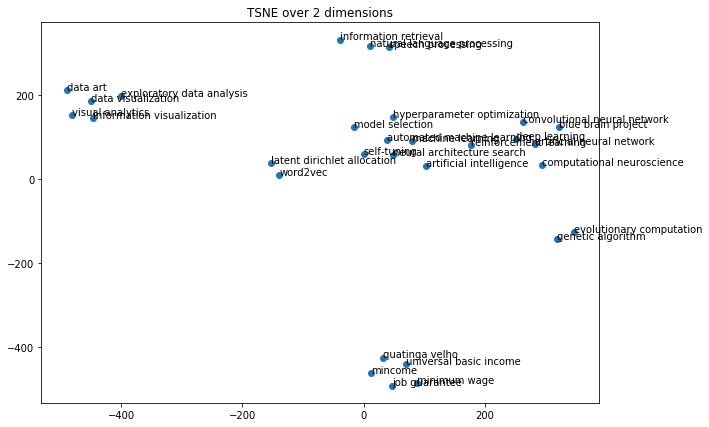

In [40]:
node_vectors = get_vectors_fasttext(nodes_to_plot,walk_averaged_embeddings_dict_fastt)
plot_projection(node_vectors, nodes_to_plot, projection_method=TSNE, perplexity=4)

In [41]:
def all_queries_print(all_queries):
    for query in all_queries:
        print("\n----------\n")
        print(query)
        print("Node2Vec")
        pprint((query_answers_node2vec(query, node2vec_model, df_node, 10, return_idx=False)))
        print("Spectral")
        pprint(query_answers_spectral(query, proj, ordered_nodes, df_node, name2idx_adjacency, topn=10, return_idx=False))
        print("FastText")
        pprint((query_answers_fasttext(query,vectors,walk_averaged_embeddings_dict_fastt,df_node,topn=10, return_idx=False)))

In [43]:
%%capture cap --no-stderr
all_queries_print(all_queries)
with open('output.txt', 'w') as f:
    f.write(cap.stdout)